In [ ]:
import glob
import time
import numpy as np
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from scipy import spatial
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.io import imread,imshow
import time

In [ ]:
model_name = "openai/clip-vit-base-patch16" # you can change model name here with patch size -- search in Hugging face.
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
classes = [
    "airplane", "ball", "car", "cat", "dolphin",
    "face", "lotus", "pickles"]

captions = [f"a picture of a {label}" for label in classes]

In [ ]:
query_paths = sorted(glob.glob('./*.jpg'))
database_paths = sorted(glob.glob('./database/*.jpg'))

In [ ]:
def pre_processing(classes, path_list) :
  captions = [f"a picture of a {label}" for label in classes]
  images = [Image.open(img).convert("RGB") for img in path_list]
  return  processor(text=captions, images=images, return_tensors="pt", padding=True)

In [ ]:
def run_model (inputs) :
  with torch.no_grad():
        outputs = model(**inputs)
  return outputs

In [ ]:
def embed_image_list (classes, path_list) :

  inputs = pre_processing(classes,path_list)

  outputs = run_model (inputs)

  embedded_list = []

  features = outputs.image_embeds.cpu().numpy()

  for i in range(0,len(features)) :
    embedded_list.append((features[i], path_list[i].split('/')[-1]))

  return embedded_list

In [ ]:
query_embedding = embed_image_list(classes,query_paths)
database_embedding = embed_image_list(classes,database_paths)

In [ ]:
def get_scores(metric, query_list, db_list) :
    score_list = []

    for q in query_list :
        l = []
        for im in db_list :
           score = 0
           if (metric == "cosine") :
               score = spatial.distance.cosine(q[0],im[0])
           elif (metric == "canberra") :
                 score = spatial.distance.canberra(q[0],im[0])
           l.append((score,im[1]))
        l.sort(key = lambda x : x[0])
        score_list.append({"name" : q[1], "score_list" : l})
    return score_list

In [ ]:
cosine_scores = get_scores('cosine', query_embedding, database_embedding)
print(cosine_scores)

[{'name': 'airplane_query.jpg', 'score_list': [(0.133599144244114, 'airplane_3.jpg'), (0.1514187455177307, 'airplane_2.jpg'), (0.16173213720321655, 'airplane_5.jpg'), (0.1892851478287475, 'airplane_1.jpg'), (0.20476493849649802, 'airplane_4.jpg'), (0.3758628182370308, 'car_1.jpg'), (0.38242924213409424, 'car_5.jpg'), (0.39677594294476315, 'cat_1.jpg'), (0.39722931385040283, 'cat_4.jpg'), (0.40416502952575684, 'dolphin_3.jpg'), (0.4051108956336975, 'cat_3.jpg'), (0.40553945302963257, 'car_4.jpg'), (0.4074408831429742, 'ball_3.jpg'), (0.4142373625706838, 'car_3.jpg'), (0.4154593596136178, 'cat_2.jpg'), (0.41882382091354764, 'ball_4.jpg'), (0.4252405509209294, 'lotus_1.jpg'), (0.42714717549962755, 'dolphin_1.jpg'), (0.4351967313768418, 'ball_2.jpg'), (0.448349151113679, 'dolphin_4.jpg'), (0.4500772953033447, 'cat_5.jpg'), (0.4533010721206665, 'ball_5.jpg'), (0.45401740074157715, 'ball_1.jpg'), (0.45649481338324005, 'car_2.jpg'), (0.46101566916797476, 'dolphin_5.jpg'), (0.47869376774709704

In [ ]:
#average score for each categories
average_score = []

for score in cosine_scores :
    name = score['name'].split('_')[0]
    elems = []

    for elem in score['score_list'] :
        if name in elem [1] :
            elems.append(elem[0])
    average_score.append((name, sum(elems) / len(elems)))

print(average_score)

[('airplane', 0.16816002265806135), ('ball', 0.0723525848216671), ('car', 0.10843967045875653), ('cat', 0.12748865735154302), ('dolphin', 0.20945770135227218), ('face', 0.07320892836607049), ('lotus', 0.18788537119058113), ('pickles', 0.15809760100115192)]


In [ ]:
#Top 10 analysis
top_10 = []
top_5 = []
for score in cosine_scores :

    category = score['name'].split("_")[0]
    count_top_10 = 0
    count_top_5 = 0
    raking_based_on_name = [x[1] for x in score['score_list']]

    for elem in score['score_list'][:10] :
        if category in elem[1] :

          if raking_based_on_name.index(elem[1]) < 5 :
            count_top_5 = count_top_5 + 1

          count_top_10 = count_top_10 + 1

    top_5.append((category,count_top_5))
    top_10.append((category,count_top_10))

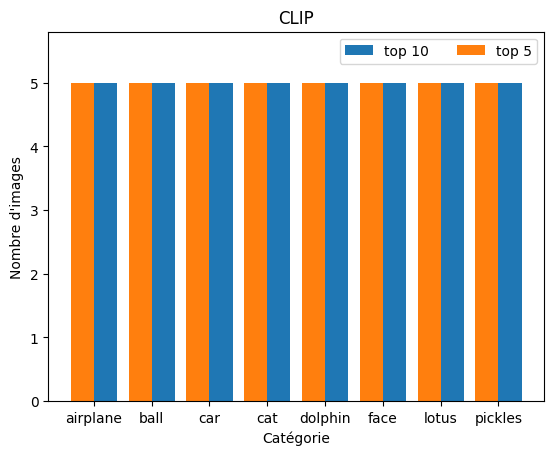

In [ ]:
name, top_10_rate = zip(*top_10)
_, top_5_rate = zip(*top_5)
x = np.arange(len(list(name)))

plt.bar(x + 0.2,list(top_10_rate), 0.4, label = 'top 10')
plt.bar(x - 0.2, list(top_5_rate), 0.4, label = 'top 5')
plt.xticks(x, list(name))
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'images")
plt.title('CLIP')
plt.ylim(0,5.8)
plt.legend(ncol=2)
plt.show()

----------------------------------------------------------TIME--------------------------------------

In [ ]:
def get_time (inputs) :
    start_time = time.time() #Getting the elapsed time
    run_model(inputs)
    end_time = time.time()
    return end_time - start_time

In [ ]:
time_table = []

#1 pic
one_pic_time = get_time(pre_processing(classes,query_paths[:1]))
time_table.append(one_pic_time)

#5 pics
five_pic_time = get_time(pre_processing(classes,query_paths[:5]))
time_table.append(five_pic_time)

#10 pics
ten_pic_time = get_time(pre_processing(classes,database_paths[:10]))
time_table.append(ten_pic_time)

#25 pics
twenty_five_pic_time = get_time(pre_processing(classes,database_paths[:25]))
time_table.append(twenty_five_pic_time)

#total (48 pics)
combined_path_array = query_paths + database_paths
all_pics_time = get_time(pre_processing(classes,combined_path_array))
time_table.append(all_pics_time)

time_table = np.round(time_table, 2)

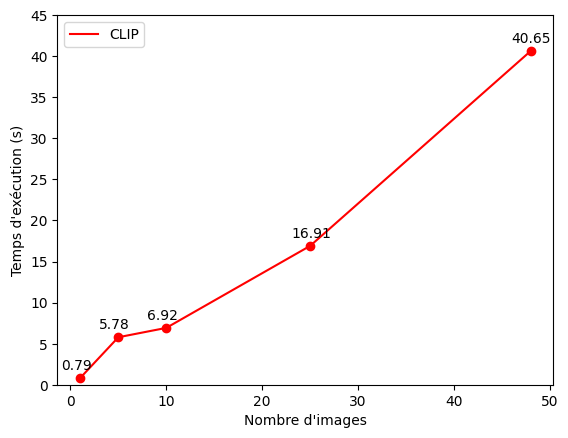

In [ ]:
#Plotting the results
plt.xlabel("Nombre d'images")
plt.ylabel("Temps d'exécution (s)")
nb_images = [1,5,10,25,48]
plt.scatter(nb_images, time_table, color = 'red')
plt.plot(nb_images, time_table, label = 'CLIP', color = 'red')
plt.ylim(0, 45)
for i, txt in enumerate(time_table):
    plt.annotate(str(txt), (nb_images[i] - 2, time_table[i] + 1))
plt.legend()
plt.show()

-------------------------------------Rotation------------------------------------------------------

In [ ]:
dolphin_ranking = cosine_scores[4]['score_list']
raking_based_on_name = [x[1] for x in dolphin_ranking]
dolphin_data = []

#get the ranking of every dolphin picture in the database
for n in range(1,6) :
    name = 'dolphin_' + str(n) + '.jpg'
    rank = raking_based_on_name.index(name)
    dolphin_data.append((name,rank + 1))
    print(name + '|' + str(rank + 1))

dolphin_1.jpg|3
dolphin_2.jpg|5
dolphin_3.jpg|2
dolphin_4.jpg|1
dolphin_5.jpg|4


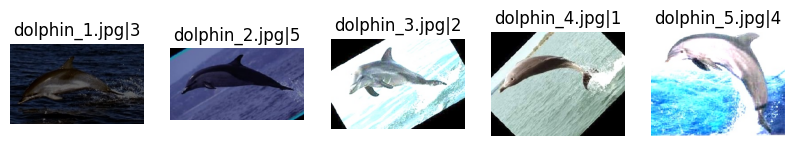

In [ ]:
fig = plt.figure(figsize=(10, 7))
dolphin_paths = sorted(list(filter(lambda x: ('dolphin' in x),database_paths )))
im_list = []

for dp in dolphin_paths :
    im_list.append(Image.open(dp))

for i in range(1,6) :
    plt.subplot(1,5,i)
    plt.imshow(im_list[i-1])
    plt.axis('off')
    plt.title(dolphin_data[i-1][0] + '|' + str(dolphin_data[i-1][1]))

plt.show()

In [ ]:
#Lets get face_5 and rotate it to see the effect
best_face = cosine_scores[5]['score_list'][3]
print('its cosine score is ' + str(best_face[0]))

its cosine score is 0.08300227916267211


In [ ]:
#Lets see how much a rotation can break face detection
query_image = imread('./face_query.jpg')
db_image =  imread('./database/' + best_face[1])

rotated_45 = rotate(db_image, -45)
rotated_90 = rotate(db_image, -90)
rotated_180 = rotate(db_image, -180)

caption = ['a picture of a face']
db_images = [db_image, rotated_45, rotated_90 ,rotated_180]

query_input = processor(text=caption , images=query_image, return_tensors="pt", padding=True)
rotation_input = processor(text=caption , images=db_images, return_tensors="pt", padding=True)

query_output = run_model(query_input)
rotation_output = run_model(rotation_input)

query_embedded = (query_output.image_embeds.cpu().numpy()[0], 'face_query.jpg')
rotation_features = rotation_output.image_embeds.cpu().numpy()

rotation_embedded = []
rotations = ['db_image','rotated_45', 'rotated_90', 'rotated_180']

for i in range(0,len(rotation_features)) :
    rotation_embedded.append((rotation_features[i], rotations[i]))

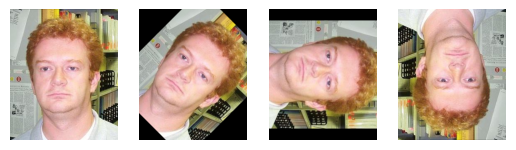

In [ ]:
#The rotated faces
for i in range(1,5) :
    plt.subplot(1,4,i)
    plt.imshow(db_images[i-1])
    plt.axis("off")
plt.show()

In [ ]:
#Interesting ....
get_scores('cosine', [query_embedded], rotation_embedded)

[{'name': 'face_query.jpg',
  'score_list': [(0.08300233382000366, 'db_image'),
   (0.4907963275909424, 'rotated_45'),
   (0.4961138367652893, 'rotated_90'),
   (0.4986317753791809, 'rotated_180')]}]

--------------------------------------------------------Bounding boxes-----------------------------------------------------------

In [ ]:
#Get the score list for the balls
ball_ranking = cosine_scores[1]['score_list']
raking_based_on_name = [x[1] for x in ball_ranking]
car_data = []

#get the score of every car picture in the database
for n in range(1,6) :
    name = 'ball_' + str(n) + '.jpg'
    rank = raking_based_on_name.index(name)
    print(name + ':' +  str(ball_ranking[rank][0]))

ball_1.jpg:0.08618366204597416
ball_2.jpg:0.04813599012660419
ball_3.jpg:0.07621753215789795
ball_4.jpg:0.05223870277404785
ball_5.jpg:0.0989870370038114


In [ ]:
#Get the scores for the bounding boxes ball images and check how much it changes the distance
classes = ['ball']
bb_paths = sorted(glob.glob("./bb_database/*.jpeg"))
query_path = bb_paths[-1:]
db_paths = bb_paths[:5]

embedded_query = embed_image_list(classes, query_path)
embedded_db = embed_image_list(classes, db_paths)

get_scores('cosine', embedded_query, embedded_db)

[{'name': 'bbBall_query.jpeg',
  'score_list': [(0.034819841384887695, 'bbBall_5.jpeg'),
   (0.043179517171318516, 'bbBall_2.jpeg'),
   (0.0795538794595455, 'bbBall_1.jpeg'),
   (0.08203909045574298, 'bbBall_3.jpeg'),
   (0.08209523803279473, 'bbBall_4.jpeg')]}]

-------------------------------------------------------------Texture---------------------------------------------------------------------------------

In [ ]:
#Lets see if clip is more influenced by the texture or by the object it self

#embedding the images
texture_paths = sorted(glob.glob('./texture_database/*.png'))
classes = ['shirt', 'bag', 'blanket', 'hat']
embedded_texture = embed_image_list(classes,texture_paths)

query = embedded_texture[-1:]
db = embedded_texture[:-1]

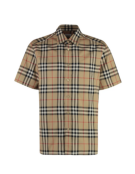

In [ ]:
#We will compare this plaid shirt
fig = plt.figure(figsize=(3, 2))
plt.axis("off")
plt.imshow(imread(sorted(texture_paths)[-1]))

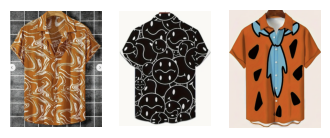

In [ ]:
#to these 3 other shirts who have differents textures
fig = plt.figure(figsize=(4, 2))
shirts = sorted(texture_paths[-4:-1])
for i in range (1,4) :
    plt.subplot(1,3,i)
    plt.imshow(imread(shirts[i-1]))
    plt.axis("off")
plt.show()

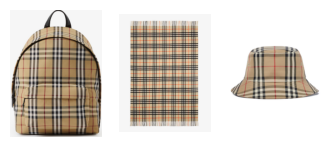

In [ ]:
#and to these 3 object (blanket, bag and hat) that have the same texture
fig = plt.figure(figsize=(4, 2))
objects = sorted(texture_paths)[0:4]
for i in range (1,4) :
    plt.subplot(1,3,i)
    plt.imshow(imread(objects[i-1]))
    plt.axis("off")
plt.show()

In [ ]:
#Now lets get the scores
get_scores('cosine',query, db)

[{'name': 'shirt_query.png',
  'score_list': [(0.13124924115840986, 'hat.png'),
   (0.1398162675122835, 'bag.png'),
   (0.17464702280479383, 'blanket.png'),
   (0.2216725217299137, 'shirt_flinstone.png'),
   (0.22420310974121094, 'shirt_abstact.png'),
   (0.28977946699979973, 'shirt_face.png')]}]